# 1. Import Required Libraries

Import the necessary libraries, including pandas, numpy, matplotlib, seaborn, nltk, and sklearn.


In [ ]:
%pip intall -r requirements.txt --quiet

In [ ]:
# run this cell if you have problems with torch gpu
# or you want to use gpu instead of cpu
%pip uninstall torch torchvision torchaudio -y --quiet
%pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu126 --quiet

In [1]:
# Import Required Libraries

import pandas as pd  # For data manipulation and analysis
import matplotlib.pyplot as plt  # For data visualization
import seaborn as sns  # For statistical data visualization
import nltk  # For natural language processing

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split  # For splitting the dataset
from sklearn.feature_extraction.text import (
    TfidfVectorizer,
)  # For text vectorization
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    recall_score,
    precision_score,
    classification_report,
    confusion_matrix,
)  # For model evaluation
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import torch  # For tensor computation

# 2. Load Datasets

Load the tweets dataset using pandas.
we used 2 datasets

- `sentiments140` :This dataset contains 1.6 million tweets labeled as positive, negative
- `COVID-19 Tweets Sentiment Dataset`: This dataset contains tweets related to COVID-19, labeled as positive, negative, or neutral. It is used to understand public sentiment and behavior during the COVID-19 outbreak.


In [2]:
import os

DATA_DIR = "./data/"
if not os.path.exists(DATA_DIR):
    os.makedirs(DATA_DIR)

DATASETS_DIR = os.listdir(DATA_DIR)
print(DATASETS_DIR)

RESULTS_DIR = "./results/covid19/"
if not os.path.exists(RESULTS_DIR):
    os.makedirs(RESULTS_DIR)

['cleaned_tweets.csv', 'combined_test.csv', 'combined_train.csv', 'corona_nlp_test.csv', 'corona_nlp_train.csv', 'covid19_tweets_test_df_processed.csv', 'covid19_tweets_train_df_processed.csv', 'models_evaluations_results.csv', 'sentiment140.csv', 'sentiment140_df_processed.csv']


In [15]:
# Load Covid 19 Dataset

# Load the tweets dataset using pandas
covid19_tweets_train_df = pd.read_csv(
    f"{DATA_DIR}/corona_nlp_train.csv", encoding="ISO-8859-1"
)
covid19_tweets_test_df = pd.read_csv(
    f"{DATA_DIR}/corona_nlp_test.csv", encoding="ISO-8859-1"
)

print(
    covid19_tweets_train_df.shape
)  # Display the number of rows and columns in the dataset
print(
    covid19_tweets_test_df.shape
)  # Display the number of rows and columns in the dataset
# Display the first few rows of the dataset to understand its structure
covid19_tweets_train_df.head()

(41157, 6)
(3798, 6)


,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative


# 3. Data Preprocessing

Handle missing values, duplicates, and other data cleaning tasks. And transform dataset to be uniform


## 3.1. Covid 19 Dataset


In [4]:
# check for missing values in the dataset
print(covid19_tweets_train_df.isna().sum())  # Check for missing values in the dataset
print(covid19_tweets_test_df.isna().sum())  # Check for missing values in the dataset

UserName            0
ScreenName          0
Location         8590
TweetAt             0
OriginalTweet       0
Sentiment           0
dtype: int64
UserName           0
ScreenName         0
Location         835
TweetAt            0
OriginalTweet      0
Sentiment          0
dtype: int64


In [16]:
# replace the missing locations with unknown
# The `Location` attribute is used exclusively for visualization purposes in our workflow.
# Since missing location data does not affect model performance, we fill these null values with "Unknown" instead of dropping the corresponding records.
if "Location" in covid19_tweets_train_df.columns:
    covid19_tweets_train_df["Location"] = covid19_tweets_train_df["Location"].fillna(
        "Unknown"
    )

if "Location" in covid19_tweets_test_df.columns:
    covid19_tweets_test_df["Location"] = covid19_tweets_test_df["Location"].fillna(
        "Unknown"
    )

In [17]:
# check for missing values in the dataset
print(covid19_tweets_train_df.isna().sum())  # Check for missing values in the dataset
print(covid19_tweets_test_df.isna().sum())  # Check for missing values in the dataset

UserName         0
ScreenName       0
Location         0
TweetAt          0
OriginalTweet    0
Sentiment        0
dtype: int64
UserName         0
ScreenName       0
Location         0
TweetAt          0
OriginalTweet    0
Sentiment        0
dtype: int64


In [18]:
# Data Preprocessing


# Remove duplicate rows to ensure data quality
covid19_tweets_train_df.drop_duplicates(inplace=True)
covid19_tweets_test_df.drop_duplicates(inplace=True)

# Display the shape of the dataset after cleaning
print(covid19_tweets_train_df.shape)
print(covid19_tweets_test_df.shape)
# connvert the sentiments classes into two classes positive and negative by grouping the extreme classes

# Basic statistics of the dataset to understand its distribution
print(
    "------covid19 train dataframe info:------------",
    covid19_tweets_train_df.info(),
    sep="\n",
)
print(
    "------covid19 test dataframe info:-------------",
    covid19_tweets_test_df.info(),
    sep="\n",
)

(41157, 6)
(3798, 6)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41157 entries, 0 to 41156
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   UserName       41157 non-null  int64 
 1   ScreenName     41157 non-null  int64 
 2   Location       41157 non-null  object
 3   TweetAt        41157 non-null  object
 4   OriginalTweet  41157 non-null  object
 5   Sentiment      41157 non-null  object
dtypes: int64(2), object(4)
memory usage: 1.9+ MB
------covid19 train dataframe info:------------
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3798 entries, 0 to 3797
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   UserName       3798 non-null   int64 
 1   ScreenName     3798 non-null   int64 
 2   Location       3798 non-null   object
 3   TweetAt        3798 non-null   object
 4   OriginalTweet  3798 non-null   object
 5   Sentiment   

In [19]:
# checking unique values in the dataset
print("covid test dataset unique values: ", covid19_tweets_test_df.nunique(), sep="\n")
print(
    "covid train dataset unique values: ", covid19_tweets_train_df.nunique(), sep="\n"
)

covid test dataset unique values: 
UserName         3798
ScreenName       3798
Location         1701
TweetAt            15
OriginalTweet    3798
Sentiment           5
dtype: int64
covid train dataset unique values: 
UserName         41157
ScreenName       41157
Location         12220
TweetAt             30
OriginalTweet    41157
Sentiment            5
dtype: int64


In [21]:
print("covid test data types: ", covid19_tweets_test_df.dtypes, sep="\n")
print("covid train data types: ", covid19_tweets_train_df.dtypes, sep="\n")

covid test data types: 
UserName          int64
ScreenName        int64
Location         object
TweetAt          object
OriginalTweet    object
Sentiment        object
dtype: object
covid train data types: 
UserName          int64
ScreenName        int64
Location         object
TweetAt          object
OriginalTweet    object
Sentiment        object
dtype: object


In [22]:
# Convert TweetAt column to datetime
covid19_tweets_train_df["TweetAt"] = pd.to_datetime(
    covid19_tweets_train_df["TweetAt"], utc=True
)

# extract the year and month from the date column for better understanding of trends
covid19_tweets_train_df["year"] = covid19_tweets_train_df["TweetAt"].dt.year
covid19_tweets_train_df["month"] = covid19_tweets_train_df["TweetAt"].dt.month

/tmp/ipykernel_16503/3216855193.py:2: UserWarning: Parsing dates in %d-%m-%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  covid19_tweets_train_df["TweetAt"] = pd.to_datetime(


In [23]:
covid19_tweets_train_df.loc[:, "text_length"] = covid19_tweets_train_df.loc[
    :, "OriginalTweet"
].apply(len)
covid19_tweets_test_df.loc[:, "text_length"] = covid19_tweets_test_df.loc[
    :, "OriginalTweet"
].apply(len)

## 3.3. Dataset transformation

transform both datasets to use the same structures and columns names


In [ ]:
#  rename the columns from covid19 dataset
covid19_tweets_train_df.rename(
    columns={"OriginalTweet": "text", "TweetAt": "date"},
    inplace=True,
)
covid19_tweets_test_df.rename(
    columns={"OriginalTweet": "text", "TweetAt": "date"},
    inplace=True,
)

In [25]:
#  drop the columns that are not essintial
covid19_tweets_train_df.drop(columns=["UserName", "ScreenName"], inplace=True)
covid19_tweets_test_df.drop(columns=["UserName", "ScreenName"], inplace=True)

# 4. Exploratory Data Analysis

Perform EDA to understand the distribution of sentiments, tweet lengths, and other relevant insights.


## 4.1. Ploting Sentiment distrubtion


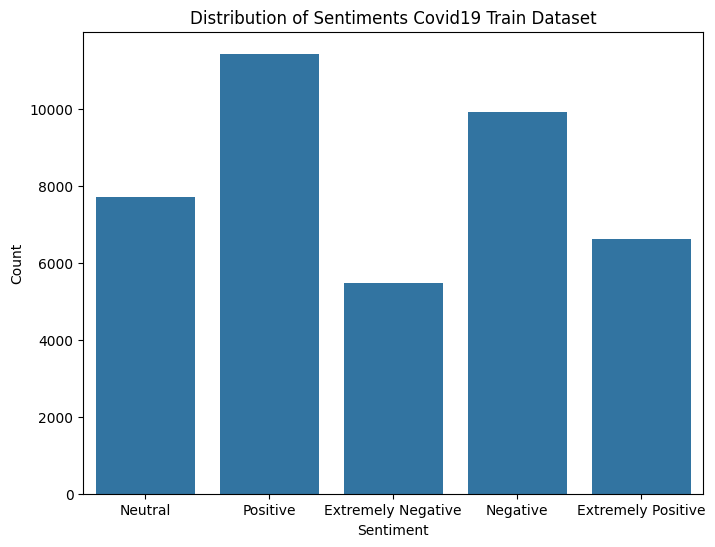

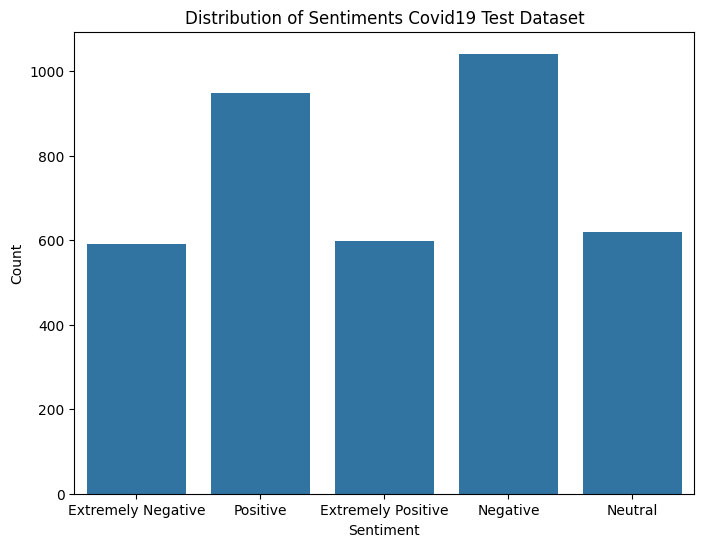

In [26]:
# Distribution of sentiments
def plot_sentiments_distribution(dataset, sentiment_column: str, title: str):
    """
    Function to plot the distribution of sentiments in the dataset
    """
    plt.figure(figsize=(8, 6))
    sns.countplot(x=sentiment_column, data=dataset)
    plt.title(title)
    plt.xlabel("Sentiment")
    plt.ylabel("Count")
    plt.savefig(f"{RESULTS_DIR}/{title}.png")
    plt.show()


plot_sentiments_distribution(
    covid19_tweets_train_df,
    "Sentiment",
    "Distribution of Sentiments Covid19 Train Dataset",
)
plot_sentiments_distribution(
    covid19_tweets_test_df,
    "Sentiment",
    "Distribution of Sentiments Covid19 Test Dataset",
)

## 4.2. Ploting tweet length distrubtion


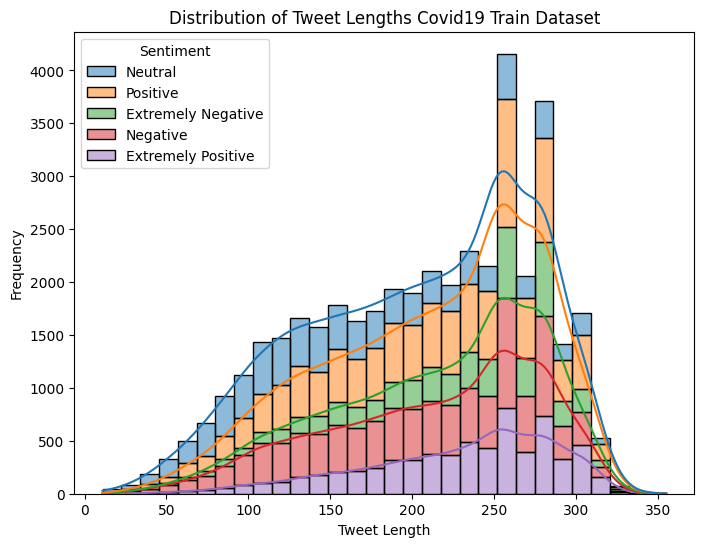

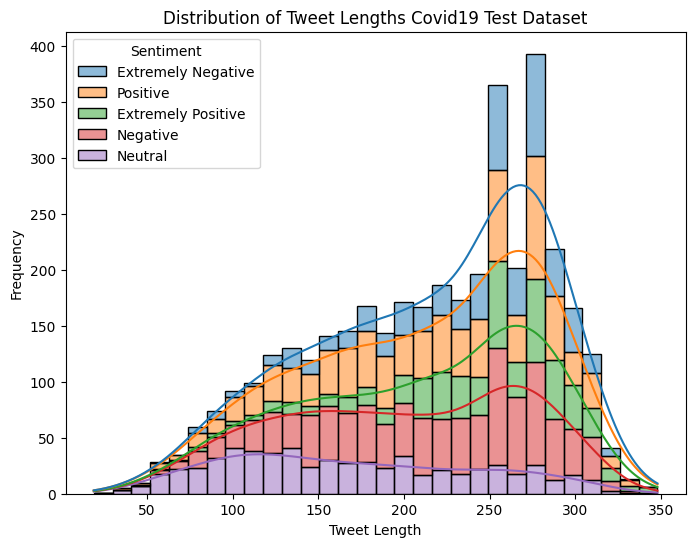

In [29]:
# Distribution of tweet lengths
def plot_tweet_length_distribution(dataset, title: str):
    """
    Function to plot the distribution of tweet lengths in the dataset
    """
    plt.figure(figsize=(8, 6))
    sns.histplot(
        data=dataset,
        x="text_length",
        hue="Sentiment",
        bins=30,
        kde=True,
        multiple="stack",
    )
    plt.title(title)
    plt.xlabel("Tweet Length")
    plt.ylabel("Frequency")
    plt.savefig(f"{RESULTS_DIR}/{title}.png")
    plt.show()


plot_tweet_length_distribution(
    covid19_tweets_train_df, "Distribution of Tweet Lengths Covid19 Train Dataset"
)
plot_tweet_length_distribution(
    covid19_tweets_test_df, "Distribution of Tweet Lengths Covid19 Test Dataset"
)


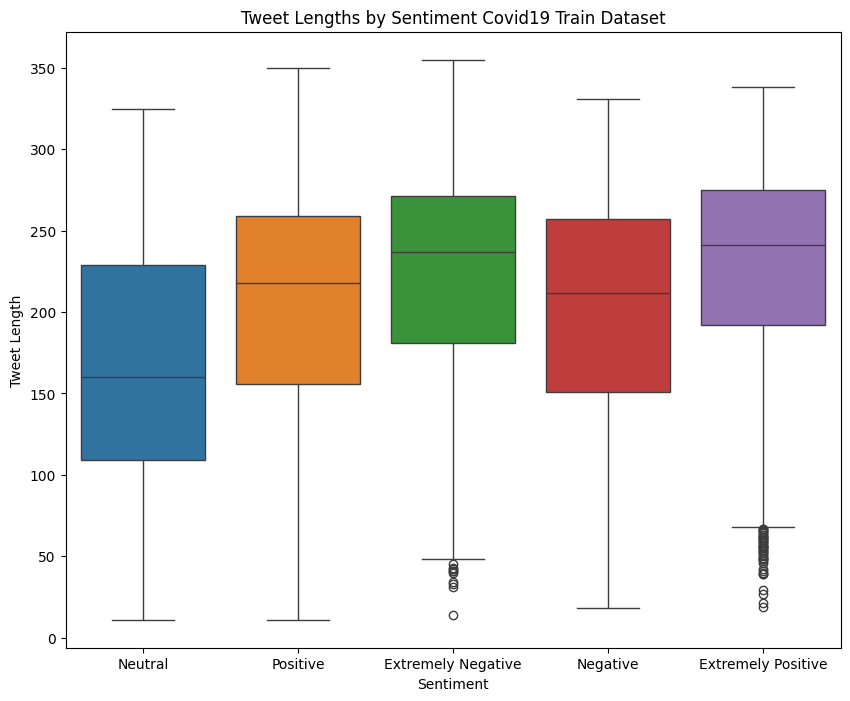

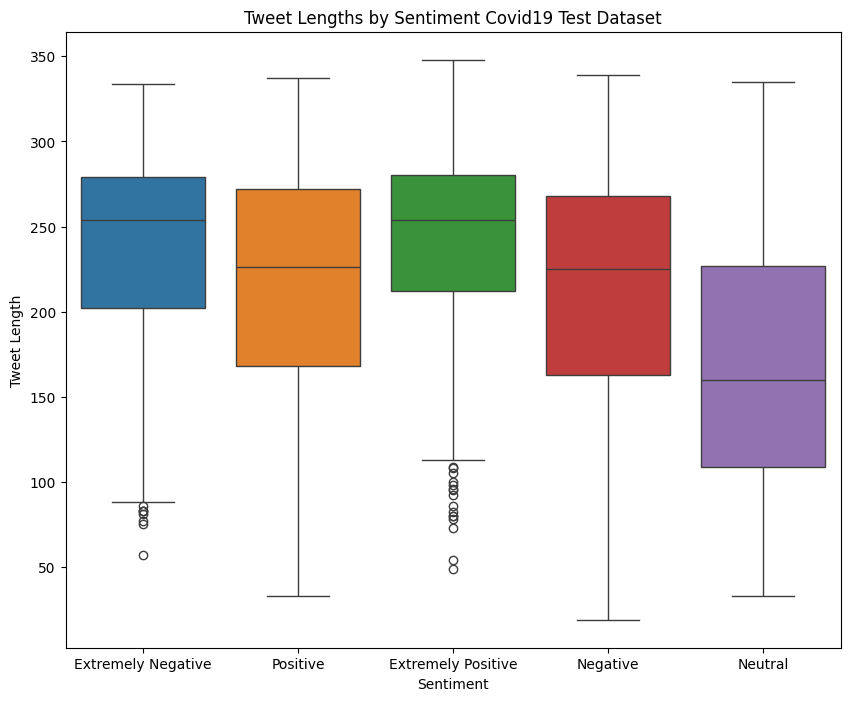

In [31]:
# Boxplot of tweet lengths by sentiment
def plot_tweet_length_by_sentiment(dataset, title: str, sentiments_column: str):
    """
    Function to plot the tweet lengths by sentiment in the dataset
    """
    plt.figure(figsize=(10, 8))
    sns.boxplot(x=sentiments_column, y="text_length", data=dataset, hue="Sentiment")
    plt.title(title)
    plt.xlabel("Sentiment")
    plt.ylabel("Tweet Length")
    plt.savefig(f"{RESULTS_DIR}/{title}.png")
    plt.show()


plot_tweet_length_by_sentiment(
    covid19_tweets_train_df,
    "Tweet Lengths by Sentiment Covid19 Train Dataset",
    "Sentiment",
)
plot_tweet_length_by_sentiment(
    covid19_tweets_test_df,
    "Tweet Lengths by Sentiment Covid19 Test Dataset",
    "Sentiment",
)

## 4.3. Ploting word clouds


In [33]:
%pip install wordcloud --quiet

Note: you may need to restart the kernel to use updated packages.


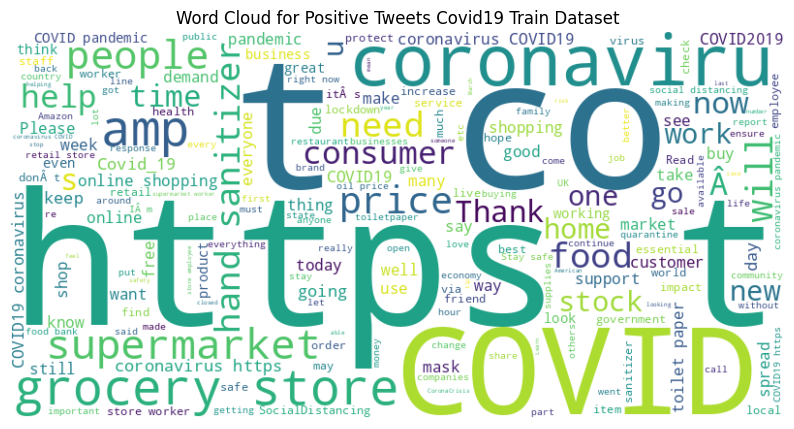

/tmp/ipykernel_16503/3493439044.py:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


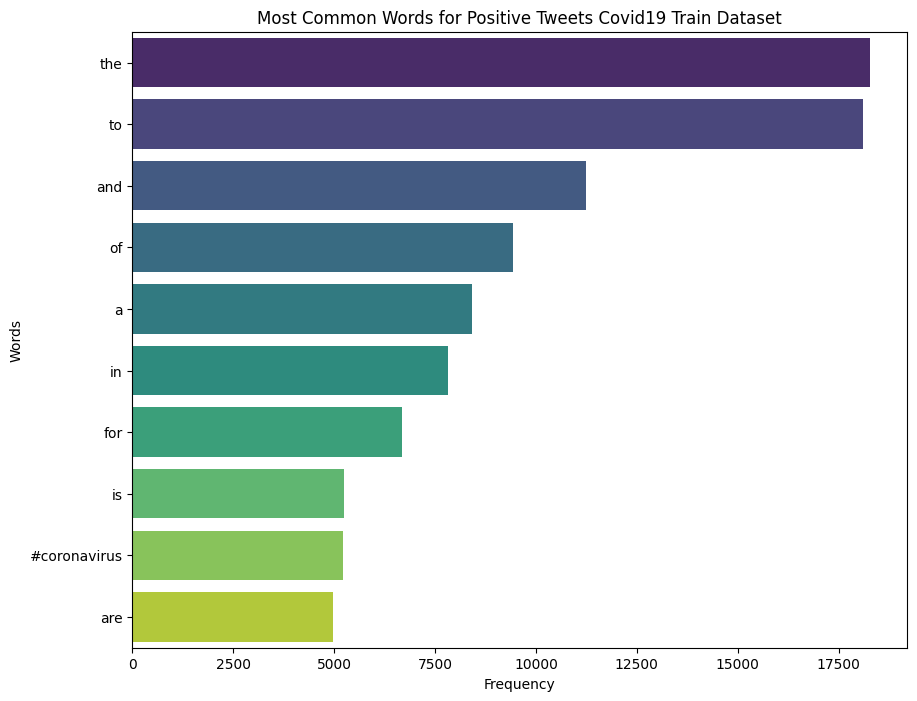

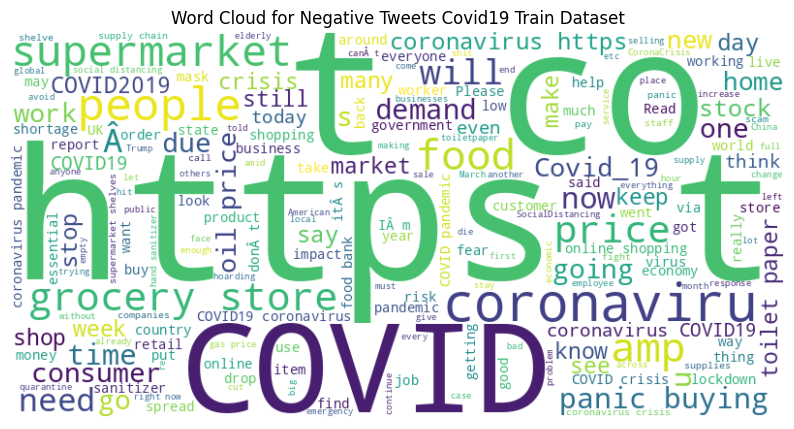

/tmp/ipykernel_16503/3493439044.py:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


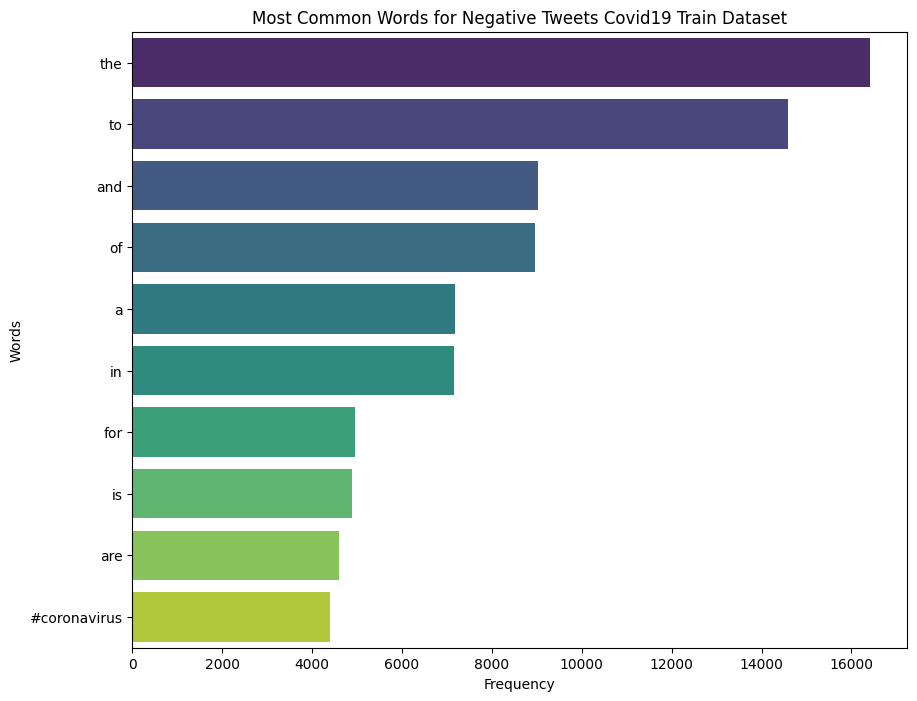

In [52]:
# Word cloud for positive tweets
from wordcloud import WordCloud
from collections import Counter


def plot_word_cloud(sentiment_tweets, title: str):
    """
    Function to plot the word cloud for the specified sentiment in the dataset
    """

    wordcloud = WordCloud(width=800, height=400, background_color="white").generate(
        sentiment_tweets
    )

    plt.figure(figsize=(10, 8))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.title(title)
    plt.axis("off")
    plt.savefig(f"{RESULTS_DIR}/{title}.png")
    plt.show()


def plot_most_common_words(sentiment_tweets, title: str):
    """
    Function to plot the most common words for the specified sentiment in the dataset
    """

    words = sentiment_tweets.split()
    word_counts = Counter(words)
    word_counts = dict(sorted(word_counts.items(), key=lambda x: x[1], reverse=True))

    plt.figure(figsize=(10, 8))
    sns.barplot(
        x=list(word_counts.values())[:10],
        y=list(word_counts.keys())[:10],
        palette="viridis",
    )
    plt.title(title)
    plt.xlabel("Frequency")
    plt.ylabel("Words")
    plt.savefig(f"{RESULTS_DIR}/{title}.png")
    plt.show()


def plot_positive_tweets(dataset, title: str, text: str):
    """
    Function to plot the positive tweets in the dataset
    """
    positive_tweets = " ".join(
        dataset[
            (
                (dataset["Sentiment"] == "Positive")
                | (dataset["Sentiment"] == "Extremely Positive")
            )
        ][text]
    )
    plot_word_cloud(positive_tweets, f"Word Cloud for Positive Tweets {title}")
    plot_most_common_words(
        positive_tweets, f"Most Common Words for Positive Tweets {title}"
    )


def plot_negative_tweets(dataset, title: str, text: str):
    """
    Function to plot the negative tweets in the dataset
    """
    negative_tweets = " ".join(
        dataset[
            (
                (dataset["Sentiment"] == "Negative")
                | (dataset["Sentiment"] == "Extremely Negative")
            )
        ][text]
    )
    plot_word_cloud(negative_tweets, f"Word Cloud for Negative Tweets {title}")
    plot_most_common_words(
        negative_tweets, f"Most Common Words for Negative Tweets {title}"
    )


plot_positive_tweets(covid19_tweets_train_df, "Covid19 Train Dataset", "text")
plot_negative_tweets(covid19_tweets_train_df, "Covid19 Train Dataset", "text")


## 4.4. Ploting tweet distrubtion by date


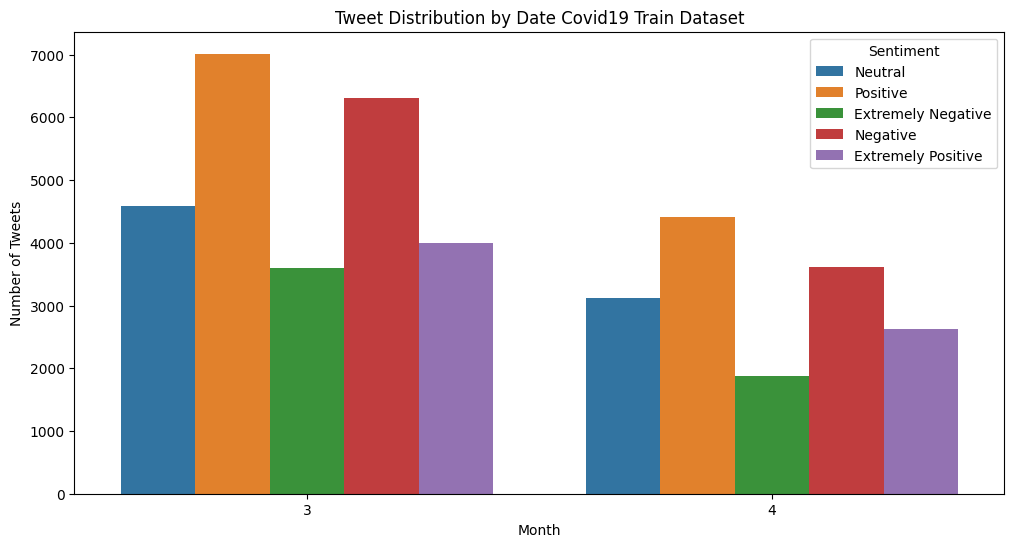

In [38]:
def plot_tweet_distribution_by_month(dataset, title: str):
    """
    Function to plot the tweet distribution by month in the dataset
    """

    plt.figure(figsize=(12, 6))
    sns.countplot(data=dataset, x="month", hue="Sentiment")
    plt.title(title)
    plt.xlabel("Month")
    plt.ylabel("Number of Tweets")
    plt.savefig(RESULTS_DIR + f"{title}.png")
    plt.show()


plot_tweet_distribution_by_month(
    covid19_tweets_train_df, "Tweet Distribution by Date Covid19 Train Dataset"
)


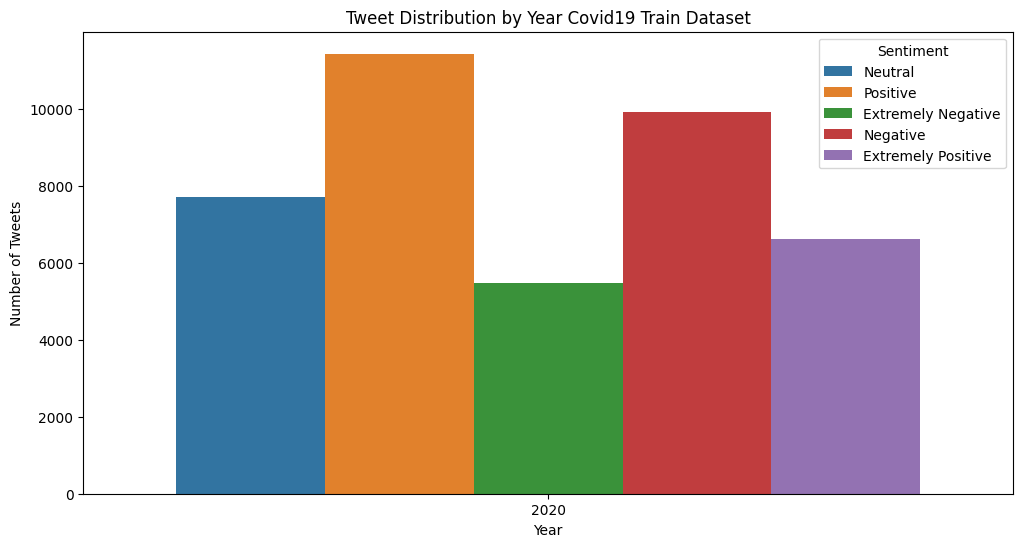

In [39]:
# visualize thetype of the tweet for by month and year
def plot_tweet_distribution_by_year(dataset, title: str):
    """
    Function to plot the tweet distribution by year in the dataset
    """

    plt.figure(figsize=(12, 6))
    sns.countplot(data=dataset, x="year", hue="Sentiment")
    plt.title(title)
    plt.xlabel("Year")
    plt.ylabel("Number of Tweets")
    plt.savefig(RESULTS_DIR + f"{title}.png")
    plt.show()


plot_tweet_distribution_by_year(
    covid19_tweets_train_df, "Tweet Distribution by Year Covid19 Train Dataset"
)

## 4.5. Ploting tweets by location


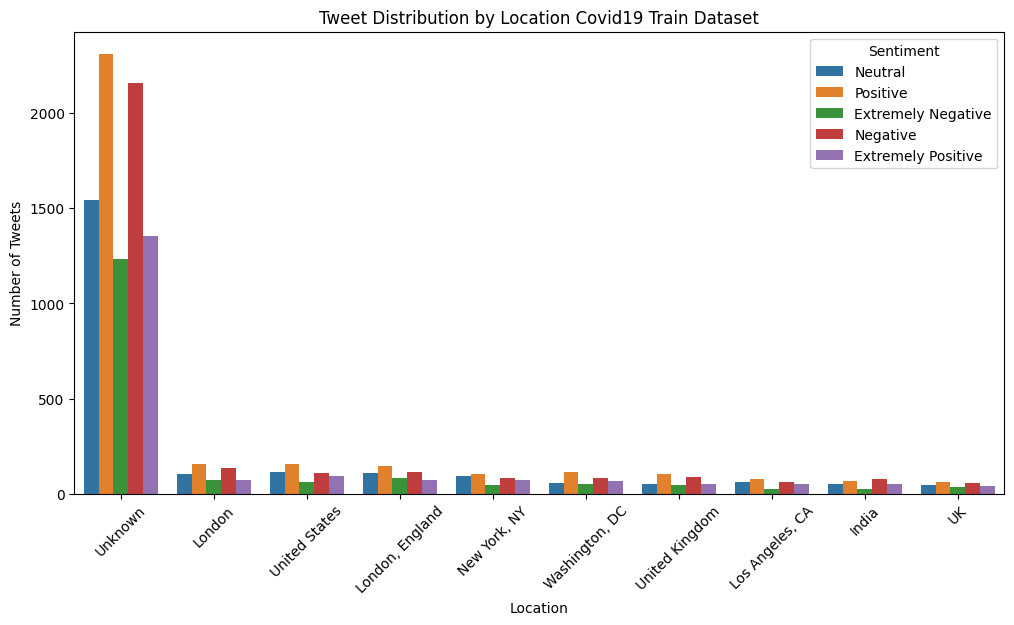

In [41]:
# ploting the distrubtion of tweets byy location
plt.figure(figsize=(12, 6))
sns.countplot(
    data=covid19_tweets_train_df,
    x="Location",
    order=covid19_tweets_train_df["Location"].value_counts().index[:10],
    hue="Sentiment",
)
plt.title("Tweet Distribution by Location Covid19 Train Dataset")
plt.xlabel("Location")
plt.ylabel("Number of Tweets")
plt.xticks(rotation=45)
plt.savefig(RESULTS_DIR + "Tweet Distribution by Location Covid19 Train Dataset.png")
plt.show()

# 5. Text Preprocessing

Preprocess the text data by removing stop words, punctuation, and applying tokenization and stemming/lemmatization.


In [42]:
print("covid19 train dataset columns: ", covid19_tweets_train_df.columns, sep="\n")
print("covid19 test dataset columns: ", covid19_tweets_test_df.columns, sep="\n")

covid19 train dataset columns: 
Index(['Location', 'date', 'text', 'Sentiment', 'year', 'month',
       'text_length'],
      dtype='object')
covid19 test dataset columns: 
Index(['Location', 'date', 'text', 'Sentiment', 'text_length'], dtype='object')


In [43]:
# to ensure efficient processign we will drop irelevant columns
covid19_tweets_train_df.drop(
    columns=["date", "year", "month", "Location", "text_length"], inplace=True
)
covid19_tweets_test_df.drop(columns=["date", "Location", "text_length"], inplace=True)

In [44]:
print("covid19 train dataset columns: ", covid19_tweets_train_df.columns, sep="\n")
print("covid19 test dataset columns: ", covid19_tweets_test_df.columns, sep="\n")

covid19 train dataset columns: 
Index(['text', 'Sentiment'], dtype='object')
covid19 test dataset columns: 
Index(['text', 'Sentiment'], dtype='object')


In [45]:
# Download NLTK data
nltk.download("stopwords")
nltk.download("punkt")
nltk.download("wordnet")
nltk.download("punkt_tab")

# Load Dataset


# Text Preprocessing Function
def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()
    # Remove URLs
    text = re.sub(r"http\S+|www\S+|https\S+", "", text, flags=re.MULTILINE)
    # Remove user @ references and '#' from hashtags
    text = re.sub(r"\@\w+|\#", "", text)
    # Remove special characters, numbers, and punctuations
    text = re.sub(r"\W", " ", text)
    text = re.sub(r"\d", " ", text)
    text = re.sub(r"\s+", " ", text)
    return text


def lemetize_text(text):
    # Tokenize the text
    tokens = word_tokenize(text)
    # Lemmatize the tokens
    lemmatizer = WordNetLemmatizer()
    tokens = [
        lemmatizer.lemmatize(word)
        for word in tokens
        if word not in stopwords.words("english")
    ]
    # Join tokens back to string
    text = " ".join(tokens)
    return text


def stem_text(text):
    # Tokenize the text
    tokens = word_tokenize(text)
    # Stem the tokens
    stemmer = nltk.PorterStemmer()
    tokens = [
        stemmer.stem(word) for word in tokens if word not in stopwords.words("english")
    ]
    # Join tokens back to string
    text = " ".join(tokens)
    return text

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/oussama/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/oussama/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /home/oussama/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /home/oussama/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [46]:
# Apply preprocessing to the text column
import time

for name, dataset in {
    "covid19_tweets_train_df": covid19_tweets_train_df,
    "covid19_tweets_test_df": covid19_tweets_test_df,
    # "sentiment140_df": sentiment140_df,
}.items():
    start_time = time.time()
    print(f"processing {name} ...")
    print("start cleaning text ...")
    dataset["clean_text"] = dataset["text"].apply(preprocess_text)
    print("finished cleaning text after ", time.time() - start_time, " seconds")
    print("lemetizing text ...")
    dataset["lemetized_text"] = dataset["clean_text"].apply(lemetize_text)
    print("finished lemetizing text after ", time.time() - start_time, " seconds")
    print("stemming text ...")
    dataset["stemmed_text"] = dataset["clean_text"].apply(stem_text)
    print("finished stemming text after ", time.time() - start_time, " seconds")
    dataset.to_csv(f"{DATA_DIR}/{name}_processed.csv", index=False)
    print(
        "finished processing ",
        name,
        " after ",
        time.time() - start_time,
        " seconds",
        "saved to ",
        f"{DATA_DIR}/{name}_processed.csv",
    )
del name, dataset, start_time

processing covid19_tweets_train_df ...
start cleaning text ...
finished cleaning text after  0.717278003692627  seconds
lemetizing text ...
finished lemetizing text after  76.52318596839905  seconds
stemming text ...
finished stemming text after  156.57335948944092  seconds
finished processing  covid19_tweets_train_df  after  157.22870135307312  seconds saved to  ./data//covid19_tweets_train_df_processed.csv
processing covid19_tweets_test_df ...
start cleaning text ...
finished cleaning text after  0.06998825073242188  seconds
lemetizing text ...
finished lemetizing text after  7.544768810272217  seconds
stemming text ...
finished stemming text after  15.625772714614868  seconds
finished processing  covid19_tweets_test_df  after  15.689828395843506  seconds saved to  ./data//covid19_tweets_test_df_processed.csv


### analyse data after ccleaning


In [ ]:
# load datasets run this cell if you have already processed the data
# this cell will load the processed data
covid19_tweets_train_df = pd.read_csv(
    f"{DATA_DIR}/covid19_tweets_train_df_processed.csv"
)
covid19_tweets_test_df = pd.read_csv(f"{DATA_DIR}/covid19_tweets_test_df_processed.csv")


In [ ]:
print("covid19 train df null", covid19_tweets_train_df.isna().sum())
print("covid19 test df null", covid19_tweets_test_df.isna().sum())

covid19 train df null text              0
Sentiment         0
target            0
clean_text        0
lemetized_text    0
stemmed_text      0
dtype: int64
covid19 test df null text              0
Sentiment         0
target            0
clean_text        0
lemetized_text    0
stemmed_text      0
dtype: int64
sentiment140 df null target               0
text                 0
clean_text           0
lemetized_text    7928
stemmed_text      7928
dtype: int64


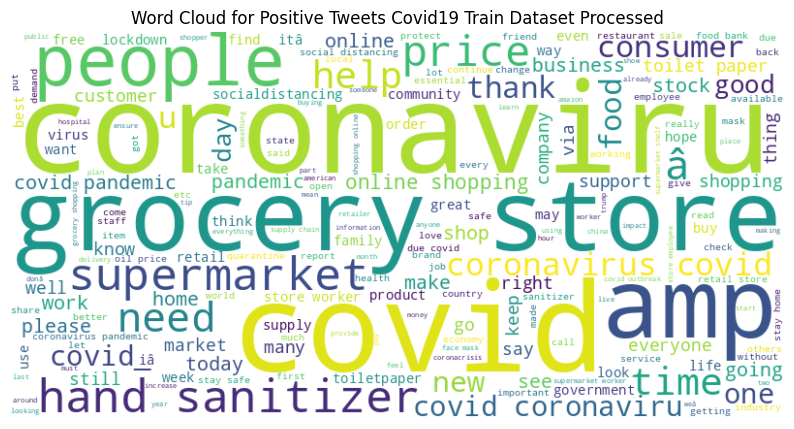

/tmp/ipykernel_16503/3493439044.py:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


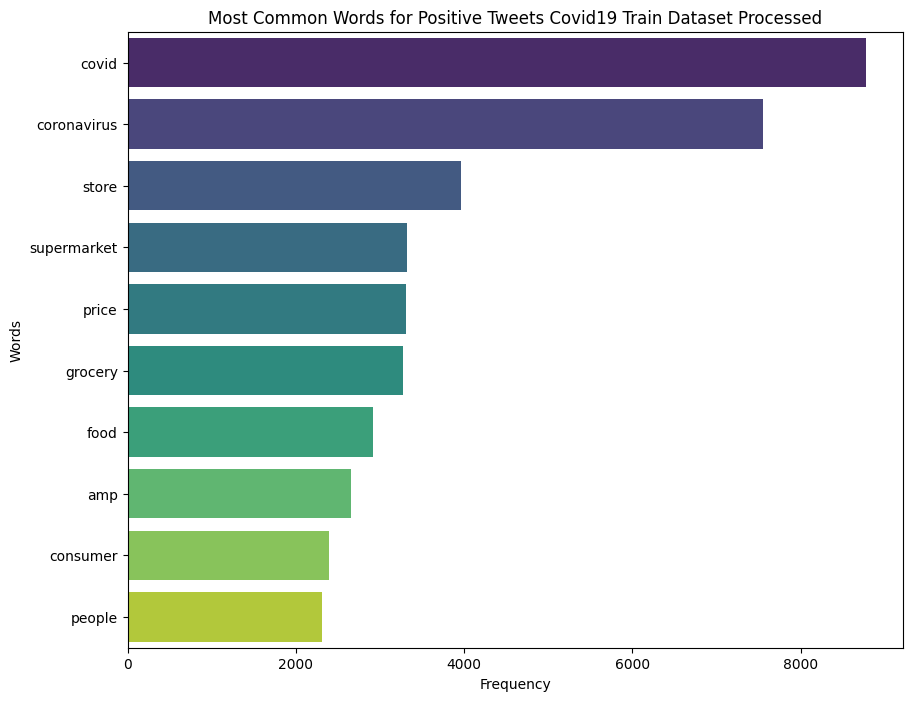

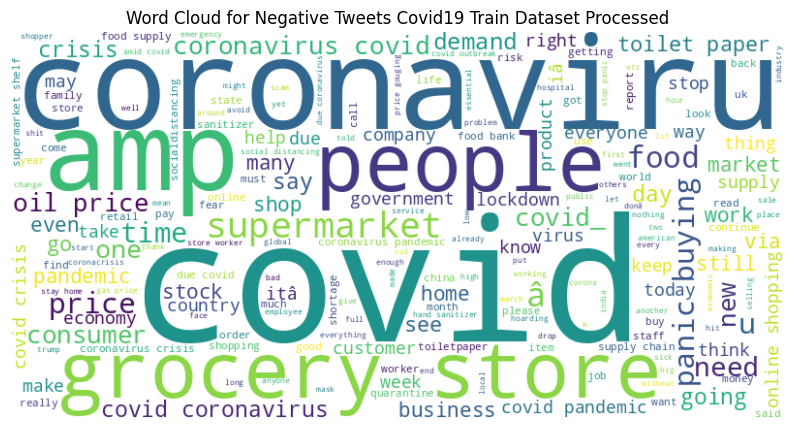

/tmp/ipykernel_16503/3493439044.py:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


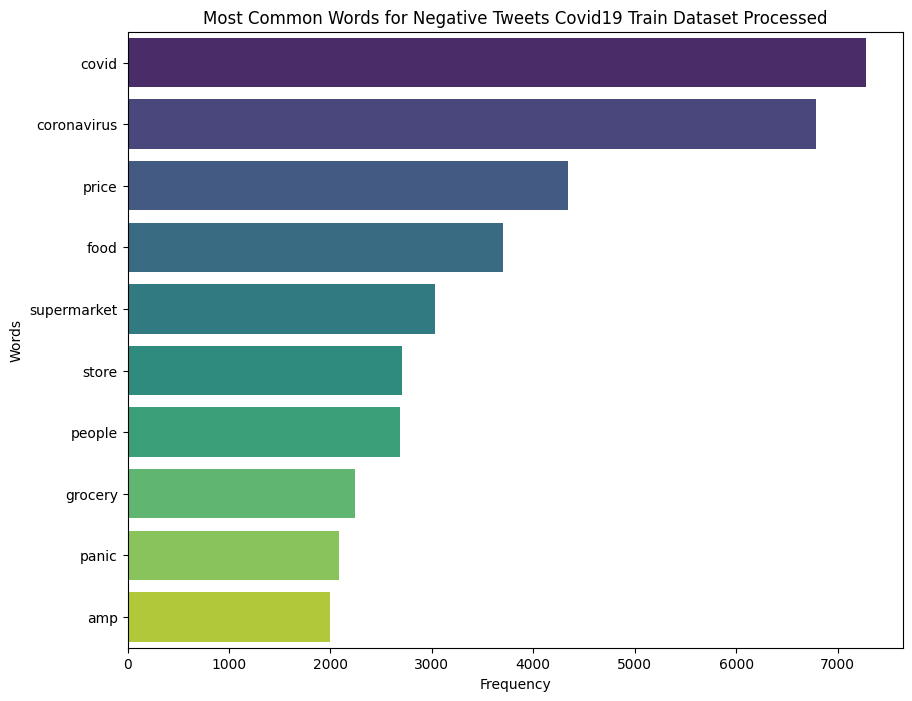

In [51]:
plot_positive_tweets(
    covid19_tweets_train_df, "Covid19 Train Dataset Processed", "lemetized_text"
)
plot_negative_tweets(
    covid19_tweets_train_df, "Covid19 Train Dataset Processed", "lemetized_text"
)


# 6. Feature Extraction

Extract features from the text data using techniques like TF-IDF or word embeddings.


In [53]:
# Feature Extraction
def generate_features(column):
    # Initialize the TF-IDF Vectorizer
    tfidf_vectorizer = TfidfVectorizer(max_features=100)

    # Fit and transform the processed tweets
    tfidf_features = tfidf_vectorizer.fit_transform(covid19_tweets_train_df[column])
    tfidf_features_test = tfidf_vectorizer.transform(covid19_tweets_test_df[column])

    # Convert the TF-IDF features to a DataFrame for better readability
    df_train = pd.DataFrame(
        tfidf_features.toarray(), columns=tfidf_vectorizer.get_feature_names_out()
    )
    df_test = pd.DataFrame(
        tfidf_features_test.toarray(),
        columns=tfidf_vectorizer.get_feature_names_out(),
    )
    return df_train, df_test

In [54]:
covid19_tweets_train_df.Sentiment.unique()

array(['Neutral', 'Positive', 'Extremely Negative', 'Negative',
       'Extremely Positive'], dtype=object)

In [55]:
# map the sentiment to classes ['Neutral', 'Positive', 'Extremely Negative', 'Negative','Extremely Positive']
sentiments = {
    "Neutral": 0,
    "Positive": 1,
    "Extremely Negative": 2,
    "Negative": 3,
    "Extremely Positive": 4,
}
covid19_tweets_train_df["Sentiment"] = covid19_tweets_train_df["Sentiment"].map(
    sentiments
)
covid19_tweets_test_df["Sentiment"] = covid19_tweets_test_df["Sentiment"].map(
    sentiments
)

# 7. Sentiment Analyses

Train a machine learning model (e.g., Logistic Regression, SVM, or a neural network) on the preprocessed data.
or use Large language models to predict sentiment from tweet text, or use statistical function to calculate polarity


In [56]:
tweets_columns = ["text", "clean_text", "lemetized_text", "stemmed_text"]

## 7.1. Classification Models

we train diffrent calassification models using the features we created early via the tfidf method here we chose random forest, logistic regression and MLP classifier


In [57]:
def evaluate_model(y_pred, y_test, model_name, column):
    """
    Function to evaluate the model using various metrics
    """
    print(f"{model_name} Model on {column}")
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average="weighted")
    recall = recall_score(y_test, y_pred, average="weighted")
    precision = precision_score(y_test, y_pred, average="weighted")
    confusion = confusion_matrix(y_test, y_pred)
    # ploting confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(confusion, annot=True, fmt="d", cmap="Blues")
    plt.title(f"{model_name} on {column} Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.savefig(f"{RESULTS_DIR}/{model_name}_{column}_confusion_matrix.png")
    plt.show()
    classification_rep = classification_report(y_test, y_pred)
    # save classification report to file
    with open(
        f"{RESULTS_DIR}/{model_name}_{column}_classification_report.txt", "w"
    ) as file:
        file.write(classification_rep)
    print(classification_rep)
    return accuracy, f1, recall, precision

In [ ]:
# Model Training
import pickle


y_train = covid19_tweets_train_df["Sentiment"]
y_test = covid19_tweets_test_df["Sentiment"]
for column in tweets_columns:
    # Initialize the models
    logistic_regression_model = LogisticRegression(max_iter=2000, n_jobs=-1, verbose=1)
    rf_model = RandomForestClassifier(
        n_jobs=-1, max_depth=1000, n_estimators=200, verbose=1
    )
    mlp_model = MLPClassifier(max_iter=2000, verbose=True)
    X_train, X_test = generate_features(column)
    # Train the Logistic Regression model
    logistic_regression_model.fit(X_train, y_train)

    # Train the SVM model
    rf_model.fit(X_train, y_train)

    # Train the MLP model
    mlp_model.fit(X_train, y_train)

    # Evaluate the Logistic Regression model
    y_pred_lr = logistic_regression_model.predict(X_test)

    lr_accuracy, lr_f1, lr_recall, lr_precision = evaluate_model(
        y_pred_lr, y_test, "Logistic Regression", column
    )

    # Evaluate the SVM model
    y_pred_rf = rf_model.predict(X_test)
    rf_accuracy, rf_f1, rf_recall, rf_precision = evaluate_model(
        y_pred_rf, y_test, "Random Forest", column
    )

    # Evaluate the MLP model
    y_pred_mlp = mlp_model.predict(X_test)
    mlp_accuracy, mlp_f1, mlp_recall, mlp_precision = evaluate_model(
        y_pred_mlp, y_test, "MLP Neural Network", column
    )

    # save the models
    with open(f"{RESULTS_DIR}/logistic_regression_{column}_model.pkl", "wb") as file:
        pickle.dump(logistic_regression_model, file)
    with open(f"{RESULTS_DIR}/random_forest_{column}_model.pkl", "wb") as file:
        pickle.dump(rf_model, file)
    with open(f"{RESULTS_DIR}/mlp_neural_network_{column}_model.pkl", "wb") as file:
        pickle.dump(mlp_model, file)

    # group all evaluation metrics into a dataframe
    metrics_df = pd.DataFrame(
        {
            "Model": ["Logistic Regression", "Random Forest", "MLP Neural Network"],
            "Accuracy": [lr_accuracy, rf_accuracy, mlp_accuracy],
            "F1 Score": [lr_f1, rf_f1, mlp_f1],
            "Recall": [lr_recall, rf_recall, mlp_recall],
            "Precision": [lr_precision, rf_precision, mlp_precision],
        }
    )
    metrics_df.to_csv(f"{RESULTS_DIR}/{column}_metrics.csv", index=False)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:  8.0min


## 7.2. Large Language Models

we use bert uncased LLM to see tohe power of LLM in the task of sentimeent analyses using diffrent preprocessing methods
in this section we will use two approaches

- `Pre-Trained Model`: we will use a pretrained model on our test datset to see how well it can perform
- `Fine-Tuning Model`: we will try and fine tune our model on our dataset and see if it can enhance it performance


### 7.2.1. Pre-Trained LLM

we used the `distilbert-base-uncased-finetuned-sst-2-english` model


In [ ]:
from transformers import pipeline

for column in tweets_columns:
    repo_name = f"{column}_pretrained"
    sentiment_pipeline = pipeline(
        "sentiment-analysis",
        model="distilbert/distilbert-base-uncased-finetuned-sst-2-english",
    )
    print(f"starting prediction of {column} using pretrained model")
    results = sentiment_pipeline(covid19_tweets_test_df[column].apply(str).tolist())

    parsed_results = [sentiments[result["label"]] for result in results]

    covid19_tweets_test_df[f"{column}_pretrained_sentiment"] = [
        result["label"] for result in results
    ]
    covid19_tweets_test_df[f"{column}_pretrained_score"] = [
        result["score"] for result in results
    ]
    evaluation = {
        "accuracy": accuracy_score(
            covid19_tweets_test_df["Sentiment"], results["label"]
        ),
        "f1": f1_score(covid19_tweets_test_df["Sentiment"], results["label"]),
        "precision": precision_score(
            covid19_tweets_test_df["Sentiment"], results["label"]
        ),
        "recall": recall_score(covid19_tweets_test_df["Sentiment"], results["label"]),
    }

    print(f"Results for {column} column using pre-trained model:")
    for key, value in evaluation.items():
        print(f"{key}: {value}")

    # plot evaluation results
    evaluation_df = pd.DataFrame(evaluation, index=[0])
    evaluation_df.to_csv(f"{RESULTS_DIR}/{repo_name}_evaluation.csv", index=False)
    evaluation_df.plot(kind="bar", figsize=(10, 6))
    plt.title(f"Sentiment Analysis Evaluation for {column}")
    plt.ylabel("Score")
    plt.savefig(f"{RESULTS_DIR}/{repo_name}_evaluation.png")

Device set to use cuda:0


starting prediction of text using pretrained model


### 7.2.2. Fine Tuning LLM

Train our LLM on our dataset


#### 7.2.2.1. Setup


In [58]:
# init the tokenizer and data collator
from transformers import AutoTokenizer
from transformers import DataCollatorWithPadding

tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [60]:
# prepare dataset transformer to fit the model
from datasets import Dataset


def prepare_dataset(df: pd.DataFrame, column_selected) -> Dataset:
    """
    this function will prepare the dataset for the model

    Args:
        df: pd.DataFrame : the cleaned dataframe
    return:
        Dataset : the dataset for the model

    """

    train = df[[column_selected, "Sentiment"]].sample(frac=0.8, random_state=1542)
    test = df[[column_selected, "Sentiment"]].drop(train.index)
    print(train.head())
    # Convert pandas DataFrames to Hugging Face datasets
    train_dataset = Dataset.from_pandas(train.reset_index(drop=True))
    eval_dataset = Dataset.from_pandas(test.reset_index(drop=True))

    # Rename columns to fit model requirements
    if column_selected != "text":
        train_dataset = train_dataset.rename_column(column_selected, "text")
        eval_dataset = eval_dataset.rename_column(column_selected, "text")
    train_dataset = train_dataset.rename_column("Sentiment", "labels")
    eval_dataset = eval_dataset.rename_column("Sentiment", "labels")
    print(train_dataset[0])
    print(eval_dataset[0])
    return train_dataset, eval_dataset


def preprocess_function(dataset):
    """this function will tokenize the dataset"""
    texts = [str(t) for t in dataset["text"]]
    return tokenizer(texts, truncation=True)

In [65]:
# define evaluation function
import numpy as np


def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    accuracy = accuracy_score(labels, predictions)
    f1 = f1_score(labels, predictions, average="weighted")
    recall = recall_score(labels, predictions, average="weighted")
    precision = precision_score(labels, predictions, average="weighted")
    return {
        "accuracy": accuracy,
        "f1": f1,
        "recall": recall,
        "precision": precision,
    }

In [62]:
# setup device for training
#  test cuda availability

os.environ["CUDA_LAUNCH_BLOCKING"] = "1"
print(torch.cuda.is_available())
# Check if CUDA is available and set device accordingly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

True
Using device: cuda


In [63]:
%pip install transformers[torch]

zsh:1: no matches found: transformers[torch]
Note: you may need to restart the kernel to use updated packages.


#### 7.2.2.2. Model Training


                                                    text  Sentiment
7542   #Coronavirus is affecting people's pocketbooks...          4
15093  Western Australia will freeze water prices as ...          1
41135  As physical stores close, clothing retailers a...          1
10280  Fed up with empty supermarket shelves? Worried...          1
11978  @sainsburys @Tesco @Morrisons @asda @AsdaServi...          3
{'text': "#Coronavirus is affecting people's pocketbooks, too. So reports the government may soon send money to everyone is good news - unless scammers take your money before you ever get a government check. The @FTC wants you know a few really important things. https://t.co/JdNGr6bTLC https://t.co/VBaHIMh4yM", 'labels': 4}
{'text': '@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/iFz9FAn2Pa and https://t.co/xX6ghGFzCC and https://t.co/I2NlzdxNo8', 'labels': 0}


/home/oussama/general-venv/lib/python3.12/site-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Map:   0%|          | 0/32926 [00:00<?, ? examples/s]

Map:   0%|          | 0/8231 [00:00<?, ? examples/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipykernel_16503/1162337585.py:45: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Training model on text column


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Epoch,Training Loss,Validation Loss,Accuracy,F1,Recall,Precision
0,No log,0.884944,0.635767,0.631984,0.635767,0.640895


Error during training: CUDA out of memory. Tried to allocate 24.00 MiB. GPU 0 has a total capacity of 5.78 GiB of which 33.56 MiB is free. Including non-PyTorch memory, this process has 5.11 GiB memory in use. Of the allocated memory 4.66 GiB is allocated by PyTorch, and 304.31 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Try reducing batch size or using CPU if CUDA memory is insufficient


/tmp/ipykernel_16503/1162337585.py:76: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


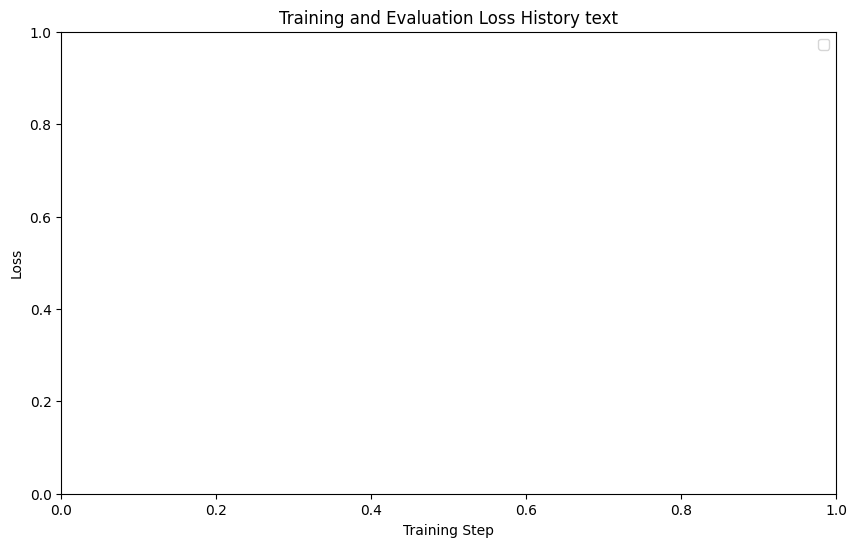

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

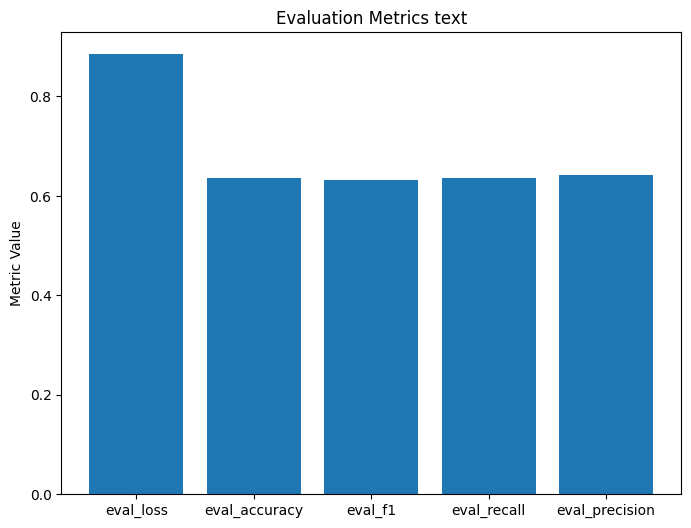

Model and tokenizer saved to tweet_sentiment_analysis_covid19_text
                                              clean_text  Sentiment
7542   coronavirus is affecting people s pocketbooks ...          4
15093  western australia will freeze water prices as ...          1
41135  as physical stores close clothing retailers ar...          1
10280  fed up with empty supermarket shelves worried ...          1
11978   can any of you help our doctors and nurses te...          3
{'text': 'coronavirus is affecting people s pocketbooks too so reports the government may soon send money to everyone is good news unless scammers take your money before you ever get a government check the wants you know a few really important things ', 'labels': 4}
{'text': ' and and ', 'labels': 0}


/home/oussama/general-venv/lib/python3.12/site-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Map:   0%|          | 0/32926 [00:00<?, ? examples/s]

Map:   0%|          | 0/8231 [00:00<?, ? examples/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipykernel_16503/1162337585.py:45: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Training model on clean_text column


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Epoch,Training Loss,Validation Loss,Accuracy,F1,Recall,Precision
1,0.987500,0.709753,0.719840,0.718723,0.719840,0.728265
2,0.628000,0.600181,0.769408,0.769122,0.769408,0.775312
3,0.508600,0.552082,0.797230,0.797536,0.797230,0.799579


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Training completed for clean_text column


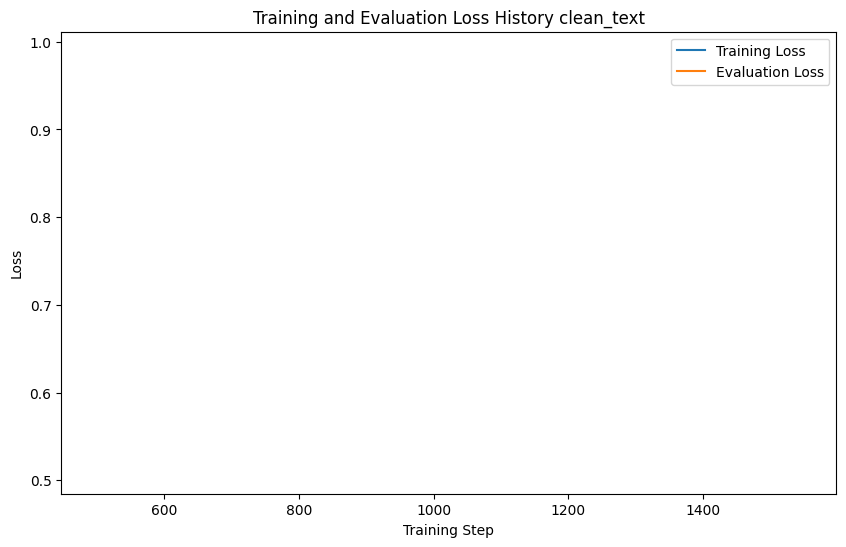

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

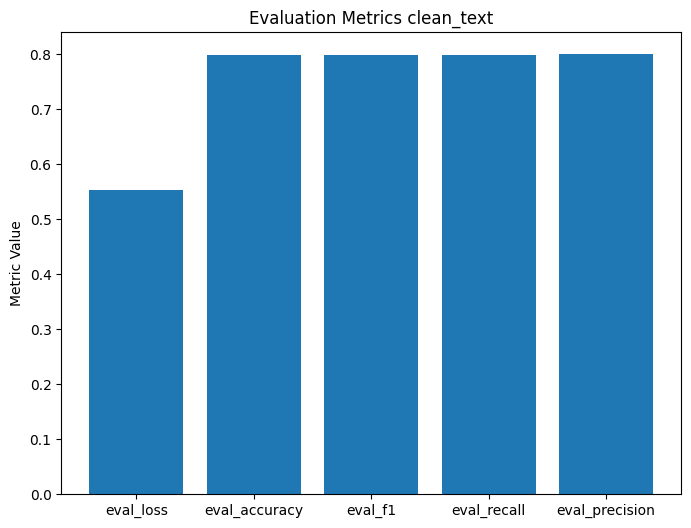

Model and tokenizer saved to tweet_sentiment_analysis_covid19_clean_text
                                          lemetized_text  Sentiment
7542   coronavirus affecting people pocketbook report...          4
15093  western australia freeze water price part econ...          1
41135  physical store close clothing retailer hoping ...          1
10280  fed empty supermarket shelf worried running mo...          1
11978  help doctor nurse tearful nurse urge public st...          3
{'text': 'coronavirus affecting people pocketbook report government may soon send money everyone good news unless scammer take money ever get government check want know really important thing', 'labels': 4}
{'text': '', 'labels': 0}


/home/oussama/general-venv/lib/python3.12/site-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Map:   0%|          | 0/32926 [00:00<?, ? examples/s]

Map:   0%|          | 0/8231 [00:00<?, ? examples/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipykernel_16503/1162337585.py:45: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Training model on lemetized_text column


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Epoch,Training Loss,Validation Loss,Accuracy,F1,Recall,Precision
1,1.043200,0.822669,0.675495,0.673962,0.675495,0.685875
2,0.734300,0.718539,0.730531,0.730325,0.730531,0.735338
3,0.637600,0.687608,0.749484,0.749797,0.749484,0.751799


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Training completed for lemetized_text column


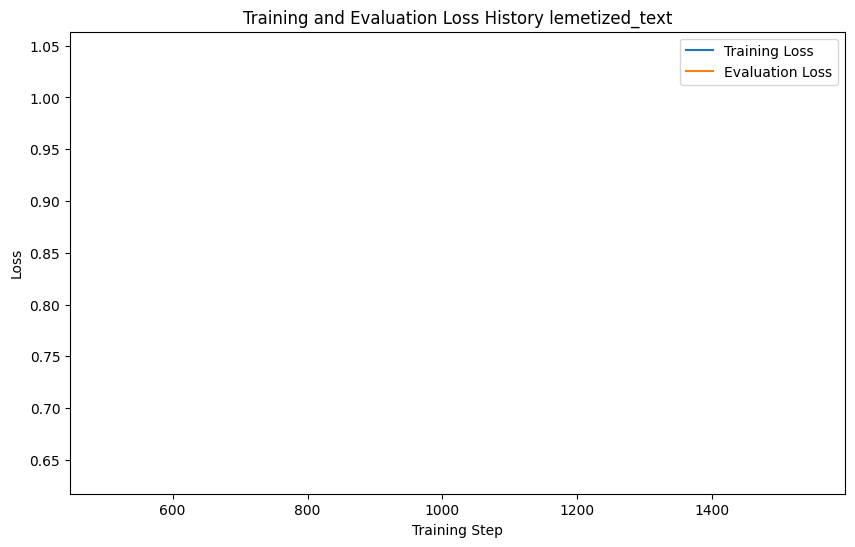

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

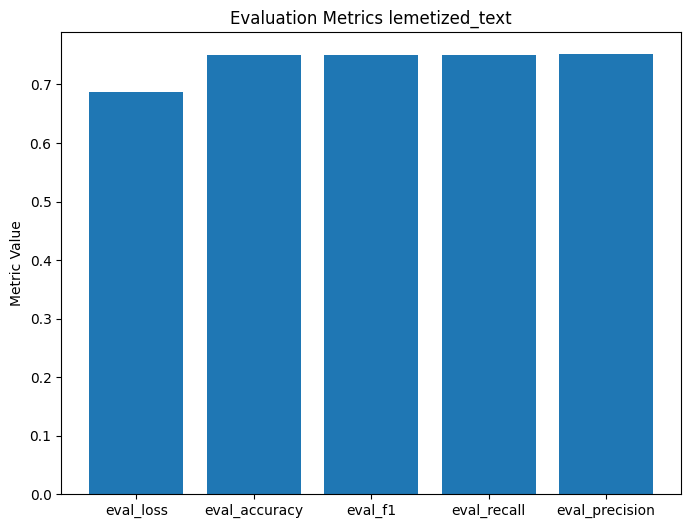

Model and tokenizer saved to tweet_sentiment_analysis_covid19_lemetized_text
                                            stemmed_text  Sentiment
7542   coronaviru affect peopl pocketbook report gove...          4
15093  western australia freez water price part econo...          1
41135  physic store close cloth retail hope onlin sal...          1
10280  fed empti supermarket shelv worri run money de...          1
11978  help doctor nurs tear nurs urg public stop pan...          3
{'text': 'coronaviru affect peopl pocketbook report govern may soon send money everyon good news unless scammer take money ever get govern check want know realli import thing', 'labels': 4}
{'text': '', 'labels': 0}


/home/oussama/general-venv/lib/python3.12/site-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Map:   0%|          | 0/32926 [00:00<?, ? examples/s]

Map:   0%|          | 0/8231 [00:00<?, ? examples/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipykernel_16503/1162337585.py:45: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Training model on stemmed_text column


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Epoch,Training Loss,Validation Loss,Accuracy,F1,Recall,Precision
1,1.145200,0.925862,0.630422,0.627594,0.630422,0.643663
2,0.853100,0.814786,0.691775,0.691370,0.691775,0.695343
3,0.748900,0.788010,0.705990,0.706512,0.705990,0.708818


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Training completed for stemmed_text column


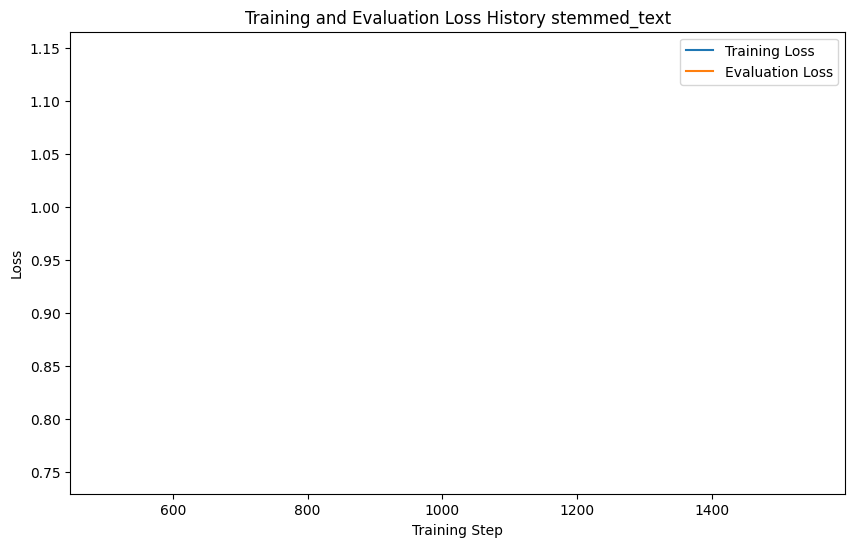

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

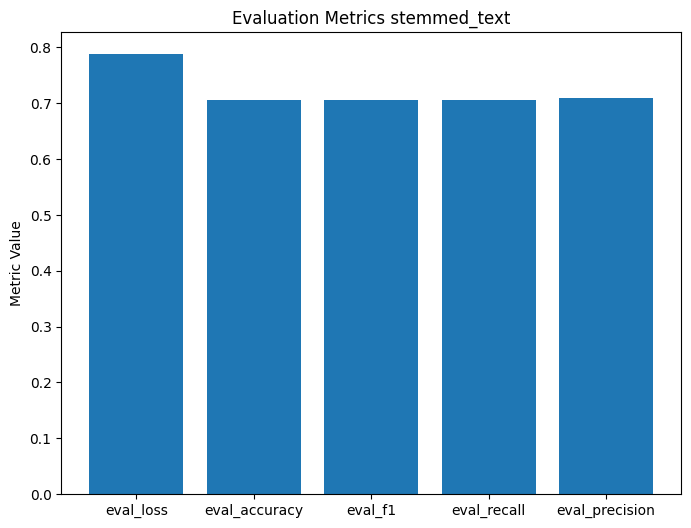

Model and tokenizer saved to tweet_sentiment_analysis_covid19_stemmed_text


In [66]:
from transformers import AutoModelForSequenceClassification, Trainer, TrainingArguments


for column in tweets_columns:
    # set name for the repo
    repo_name = f"tweet_sentiment_analysis_covid19_{column}"

    # Set up training arguments
    training_args = TrainingArguments(
        output_dir=repo_name,  # output directory
        learning_rate=2e-5,
        per_device_train_batch_size=64,  # reduced batch size
        per_device_eval_batch_size=64,  # reduced batch size
        num_train_epochs=3,
        weight_decay=0.01,
        save_strategy="epoch",
        evaluation_strategy="epoch",
        # push_to_hub=True,
        logging_dir=f"./logs/{repo_name}",
        fp16=True,  # enable mixed precision on CUDA
        dataloader_num_workers=4,
        dataloader_pin_memory=True,
    )

    #  loading dataset
    train_dataset, eval_dataset = prepare_dataset(covid19_tweets_train_df, column)
    tokenized_train = train_dataset.map(preprocess_function, batched=True)
    tokenized_test = eval_dataset.map(preprocess_function, batched=True)

    # Load model and move it to the appropriate device
    model = AutoModelForSequenceClassification.from_pretrained(
        "distilbert-base-uncased", num_labels=5
    )

    model = model.to(device)

    # Check if labels are within the expected range
    num_labels = model.config.num_labels
    for dataset in [tokenized_train, tokenized_test]:
        labels = dataset["labels"]
        if not all(0 <= label < num_labels for label in labels):
            raise ValueError(f"Found labels outside the range [0, {num_labels - 1}]")

    # Initialize Trainer
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=tokenized_train,
        eval_dataset=tokenized_test,
        tokenizer=tokenizer,
        data_collator=data_collator,
        compute_metrics=compute_metrics,
    )

    # Start training with error handling
    try:
        print(f"Training model on {column} column")
        trainer.train()
        print(f"Training completed for {column} column")
    except RuntimeError as e:
        print(f"Error during training: {e}")
        print("Try reducing batch size or using CPU if CUDA memory is insufficient")

    # Convert trainer's log_history to a DataFrame for easier plotting
    history = pd.DataFrame(trainer.state.log_history)

    # Plot training (and evaluation) loss if available
    plt.figure(figsize=(10, 6))
    if "loss" in history.columns:
        plt.plot(history["step"], history["loss"], label="Training Loss")
    if "eval_loss" in history.columns:
        plt.plot(history["step"], history["eval_loss"], label="Evaluation Loss")
    plt.xlabel("Training Step")
    plt.ylabel("Loss")
    plt.title(f"Training and Evaluation Loss History {column}")
    plt.legend()
    plt.savefig(RESULTS_DIR + f"{column}_training_eval_loss_history.png")
    plt.show()

    eval_results = trainer.evaluate()

    # Remove non-metric keys if present
    metric_keys = [
        k
        for k in eval_results.keys()
        if k
        in [
            "eval_loss",
            "eval_accuracy",
            "eval_f1",
            "eval_precision",
            "eval_recall",
        ]
    ]

    # Save the evaluation metrics into a DataFrame and export as CSV
    metrics_df = pd.DataFrame([{k: eval_results[k] for k in metric_keys}])
    metrics_df.to_csv(RESULTS_DIR + f"{column}_evaluation_metrics.csv", index=False)

    # Plot evaluation metrics as a bar chart
    plt.figure(figsize=(8, 6))
    plt.bar(metric_keys, [eval_results[k] for k in metric_keys])
    plt.ylabel("Metric Value")
    plt.title(f"Evaluation Metrics {column}")
    plt.savefig(RESULTS_DIR + f"{column}_evaluation_metrics.png")
    plt.show()

    # saving the models
    trainer.save_model(repo_name)
    tokenizer.save_pretrained(repo_name)
    print(f"Model and tokenizer saved to {repo_name}")

#### 7.2.2.3. Model Evaluation


In [69]:
# evaluate the finetuned model on test dataset
from transformers import pipeline

for column in tweets_columns:
    repo_name = f"tweet_sentiment_analysis_{column}"
    sentiment_pipeline = pipeline(
        "sentiment-analysis",
        model=f"./{repo_name}/",
    )
    results = sentiment_pipeline(covid19_tweets_test_df[column].apply(str).tolist())

    # Map the labels to the correct sentiment values
    label_mapping = {
        "LABEL_0": 0,
        "LABEL_1": 1,
        "LABEL_2": 2,
        "LABEL_3": 3,
        "LABEL_4": 4,
    }
    parsed_results = [label_mapping[result["label"]] for result in results]

    covid19_tweets_test_df[f"{column}_finetuned_sentiment"] = [
        result["label"] for result in results
    ]
    covid19_tweets_test_df[f"{column}_finetuned_score"] = [
        result["score"] for result in results
    ]
    evaluation = {
        "accuracy": accuracy_score(covid19_tweets_test_df["Sentiment"], parsed_results),
        "f1": f1_score(
            covid19_tweets_test_df["Sentiment"], parsed_results, average="weighted"
        ),
        "precision": precision_score(
            covid19_tweets_test_df["Sentiment"], parsed_results, average="weighted"
        ),
        "recall": recall_score(
            covid19_tweets_test_df["Sentiment"], parsed_results, average="weighted"
        ),
    }

    print(f"Results for {column} column using fine-tuned model:")
    for key, value in evaluation.items():
        print(f"{key}: {value}")

    # save the evaluation results
    evaluation_df = pd.DataFrame(evaluation, index=[0])
    evaluation_df.to_csv(f"{RESULTS_DIR}/{repo_name}_evaluation.csv", index=False)


Device set to use cuda:0
/home/oussama/general-venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
Device set to use cuda:0


Results for text column using fine-tuned model:
accuracy: 0.25934702474986837
f1: 0.16151370576467405
precision: 0.11807145321108731
recall: 0.25934702474986837


/home/oussama/general-venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
Device set to use cuda:0


Results for clean_text column using fine-tuned model:
accuracy: 0.2643496577145866
f1: 0.16386725823933398
precision: 0.11936501819226063
recall: 0.2643496577145866


/home/oussama/general-venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
Device set to use cuda:0


Results for lemetized_text column using fine-tuned model:
accuracy: 0.2856766719325961
f1: 0.17678695962363744
precision: 0.12950455428958715
recall: 0.2856766719325961
Results for stemmed_text column using fine-tuned model:
accuracy: 0.2740916271721959
f1: 0.16922475618774435
precision: 0.12397321512185047
recall: 0.2740916271721959


/home/oussama/general-venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


## 7.3. Statistical Model

here we use the `TextBlob` snetiment analyses methode that uses statistical calculation to calculate polarity where The sentiment property returns a namedtuple of the form Sentiment(polarity, subjectivity). The polarity score is a float within the range [-1.0, 1.0]. The subjectivity is a float within the range [0.0, 1.0] where 0.0 is very objective and 1.0 is very subjective.


In [70]:
%pip install -q textblob
from textblob import TextBlob


# Create a function to get the subjectivity
def getSubjectivity(text):
    return TextBlob(text).sentiment.subjectivity


# Create a function to get Polarity
def getPolarity(text):
    return TextBlob(text).sentiment.polarity


def getInsight(polarity):
    if polarity > 0.6:
        return "Extremely Positive"
    elif polarity > 0.2:
        return "Positive"
    elif polarity < -0.6:
        return "Extremely Negative"
    elif polarity < -0.2:
        return "Negative"
    else:
        return "Neutral"


def analyze_sentiment(df, target: str = "text"):
    # Now we create a new column for what we just did and add it to the dataframe
    print(f"Analyzing {target} using textblob sentiment analysis")
    df.dropna(subset=[target], inplace=True)
    df[f"{target}_Subjectivity"] = df[target].apply(getSubjectivity)
    df[f"{target}_Polarity"] = df[target].apply(getPolarity)
    # Group the range of Polarity into different categories
    df[f"{target}_Insight"] = df[f"{target}_Polarity"].apply(getInsight)

    return df


Note: you may need to restart the kernel to use updated packages.


Analyzing text using textblob sentiment analysis
accuracy: 0.24196945760926802
f1: 0.18663708458053502
precision: 0.33914437462065594
recall: 0.24196945760926802
column: text
Analyzing clean_text using textblob sentiment analysis
accuracy: 0.24065297525013166
f1: 0.1849422635410811
precision: 0.35834885738010913
recall: 0.24065297525013166
column: clean_text
Analyzing lemetized_text using textblob sentiment analysis
accuracy: 0.2456556082148499
f1: 0.19340965459531595
precision: 0.3484698794916896
recall: 0.2456556082148499
column: lemetized_text
Analyzing stemmed_text using textblob sentiment analysis
accuracy: 0.23170089520800422
f1: 0.1796306194294745
precision: 0.3336433120578656
recall: 0.23170089520800422
column: stemmed_text


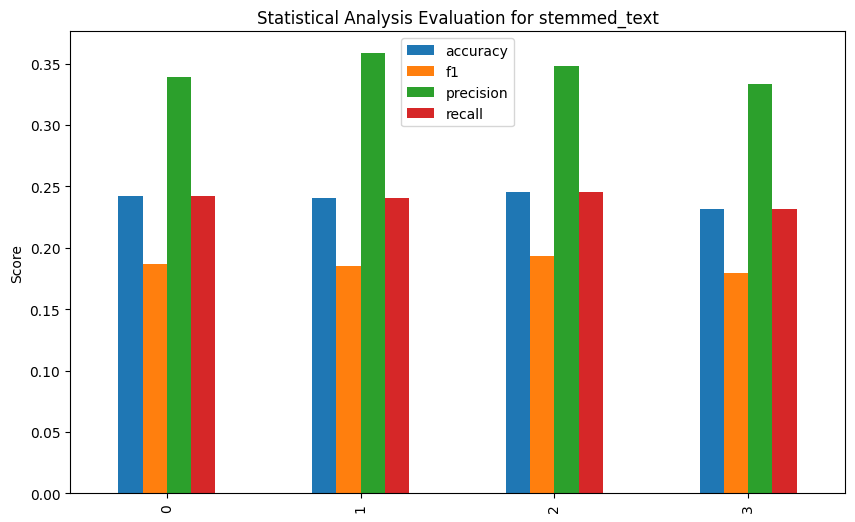

In [73]:
evaluation_df = pd.DataFrame()
for column in tweets_columns:
    df = analyze_sentiment(covid19_tweets_test_df, column)
    df[f"{column}_Polarity_Class"] = (
        df[f"{column}_Polarity"].apply(getInsight).map(sentiments)
    )
    statistical_model_evaluation = {
        "accuracy": accuracy_score(df["Sentiment"], df[f"{column}_Polarity_Class"]),
        "f1": f1_score(
            df["Sentiment"], df[f"{column}_Polarity_Class"], average="weighted"
        ),
        "precision": precision_score(
            df["Sentiment"], df[f"{column}_Polarity_Class"], average="weighted"
        ),
        "recall": recall_score(
            df["Sentiment"], df[f"{column}_Polarity_Class"], average="weighted"
        ),
        "column": column,
    }
    for key, value in statistical_model_evaluation.items():
        print(f"{key}: {value}")

    # add the evaluation to the evaluation dataframe where the columns are the evaluation metrics
    evaluation_df = pd.concat(
        [evaluation_df, pd.DataFrame([statistical_model_evaluation])], ignore_index=True
    )
    # plot and save the results

evaluation_df.to_csv(f"{RESULTS_DIR}/{column}_statistical_evaluation.csv", index=False)
evaluation_df.plot(kind="bar", figsize=(10, 6))
plt.title(f"Statistical Analysis Evaluation for {column}")
plt.ylabel("Score")
plt.savefig(f"{RESULTS_DIR}/{column}_statistical_evaluation.png")
plt.show()

## Evaluation


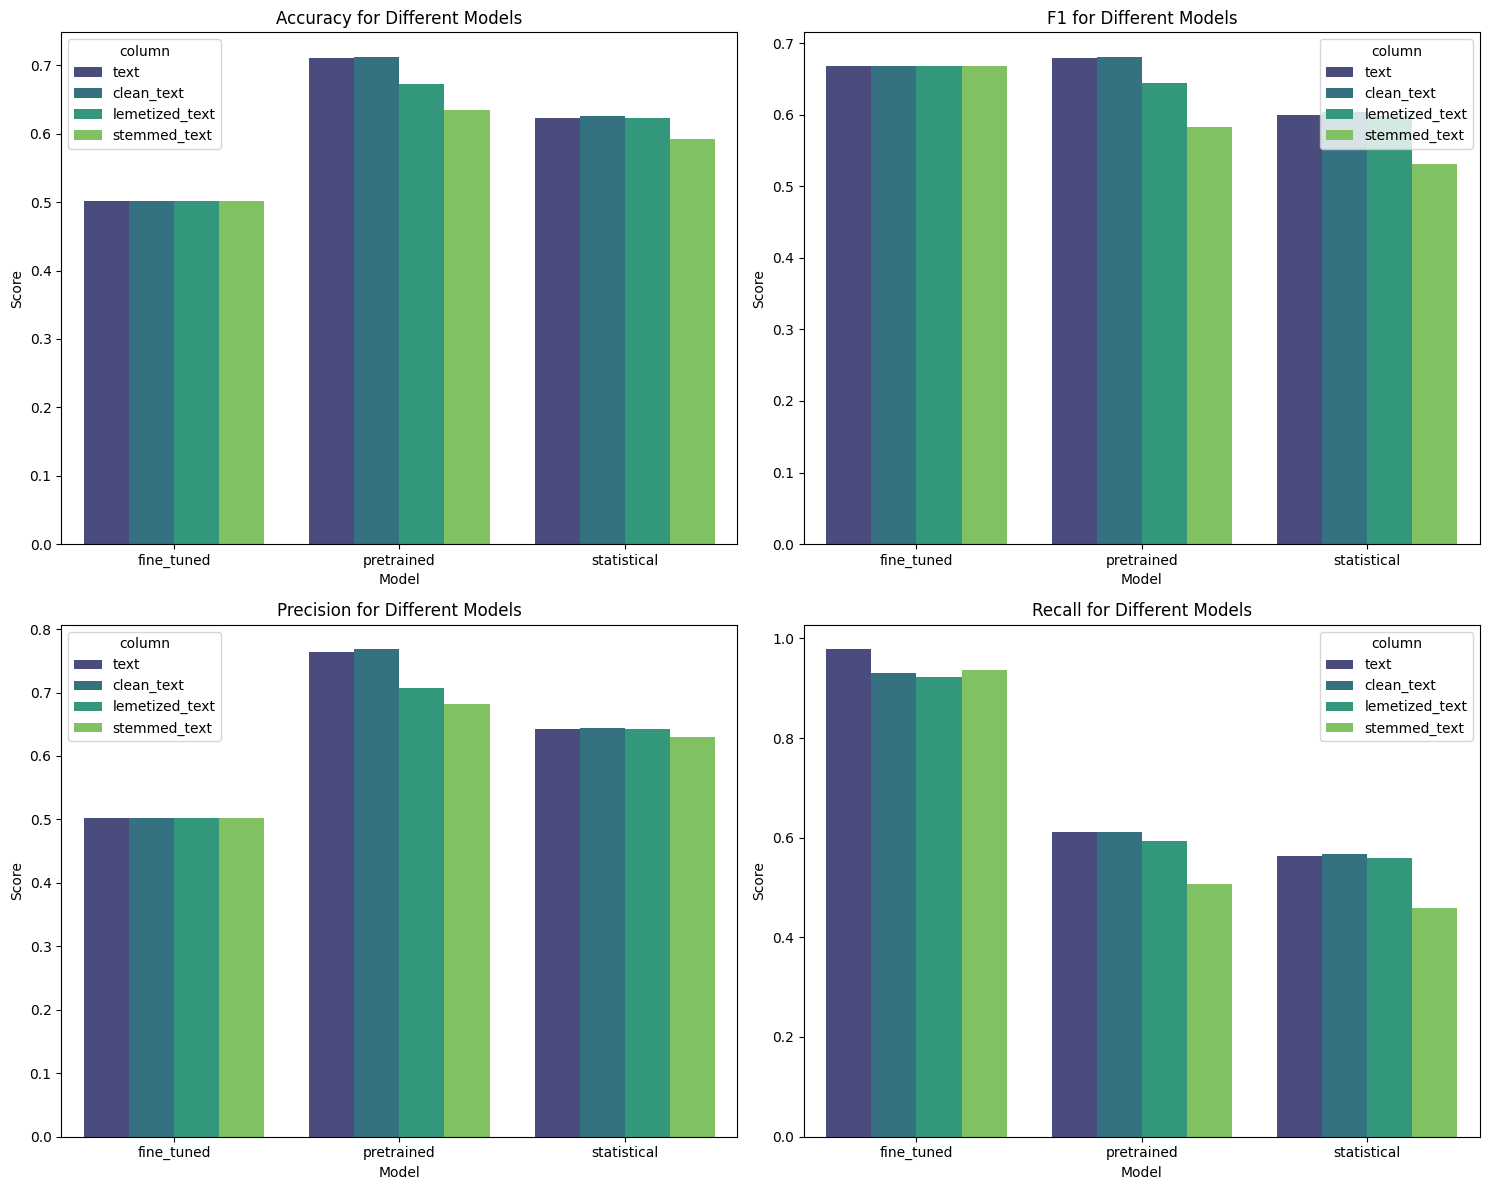

,accuracy,f1,precision,recall,model,column
0,0.501850,0.668309,0.501850,0.978412,fine_tuned,text
0,0.710576,0.679561,0.764633,0.611523,pretrained,text
0,0.623062,0.599832,0.641914,0.562928,statistical,text
0,0.501850,0.668309,0.501850,0.931255,fine_tuned,clean_text
0,0.712613,0.681185,0.768366,0.611771,pretrained,clean_text


In [37]:
# load all the past results
evaluation_results = pd.DataFrame()
for column in tweets_columns:
    fine_tuned_results = pd.read_csv(
        f"{RESULTS_DIR}/tweet_sentiment_analysis_{column}_evaluation.csv"
    )
    pretrained_results = pd.read_csv(
        f"{RESULTS_DIR}/{column}_pretrained_evaluation.csv"
    )
    statistical_results = pd.read_csv(
        f"{RESULTS_DIR}/{column}_statistical_evaluation.csv"
    )
    # group the evaluation results into a single dataframe where the columns are the evaluation metrics and we have the model name as column and the column
    # as the index
    fine_tuned_results["model"] = "fine_tuned"
    pretrained_results["model"] = "pretrained"
    statistical_results["model"] = "statistical"
    # add the current column name to the dataframe
    grouped_results = pd.concat(
        [fine_tuned_results, pretrained_results, statistical_results]
    )
    grouped_results["column"] = column
    evaluation_results = pd.concat([evaluation_results, grouped_results])

metrics = ["accuracy", "f1", "precision", "recall"]
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

for metric, ax in zip(metrics, axes.flatten()):
    sns.barplot(
        x="model",
        y=metric,
        hue="column",
        data=evaluation_results,
        palette="viridis",
        ax=ax,
    )
    ax.set_title(f"{metric.capitalize()} for Different Models")
    ax.set_ylabel("Score")
    ax.set_xlabel("Model")

plt.tight_layout()
plt.savefig(f"{RESULTS_DIR}/evaluation_metrics.png")
plt.show()
evaluation_results.to_csv(f"{RESULTS_DIR}/evaluation_results.csv", index=False)
evaluation_results.head()